# Feature Engineering and feature selection

The following notebook creates additional features from existing features to improve predictive power.

It also performs statistical tests to select only relevant features for modeling.

Once features were selected, it scales/encodes them depending on variable type.

## Contents

- [Preprocessing Pipeline](#preproc)
- [Numerical columns](#numcol)
- [Categorical columns](#catcol)

In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import calendar
from statsmodels.stats import weightstats as stests

from Utils.DataUtils import *
from Utils.VizUtils import *

In [79]:
train_data = pd.read_csv("./train_data.csv")
display(
    train_data.shape,
    train_data.head()
)

(8543, 18)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.000000,22,464.383333,0.000000,0.002273,0.000000,0.0,Nov,2,2,1,8,New_Visitor,False,False
1,9,134.766667,0,0.000000,17,347.547619,0.024242,0.042121,0.000000,0.0,May,3,2,4,4,Returning_Visitor,False,False
2,20,1307.675000,3,132.666667,517,27009.859430,0.004385,0.014594,8.403164,0.0,Nov,1,1,1,2,Returning_Visitor,False,True
3,0,0.000000,0,0.000000,5,43.500000,0.140000,0.180000,0.000000,0.0,Nov,3,3,1,3,Returning_Visitor,False,False
4,1,46.500000,0,0.000000,14,398.979167,0.000000,0.014286,116.337865,0.0,Dec,8,13,9,20,Other,False,True


In [85]:
# Quick helper variable
rev_palette = {True:'green', False:'mistyrose'}
def highlight_y(x):
    return ['background-color: green' if x["Revenue"] 
            else 'background-color: mistyrose'
            for i in x]

In [86]:
ycol = ["Revenue"]
numerical_cols = ["Administrative", "Administrative_Duration", 
                  "Informational", "Informational_Duration",
                  "ProductRelated", "ProductRelated_Duration", 
                  "BounceRates", "ExitRates", "PageValues", "SpecialDay"
                  ]
cat_cols = [c for c in train_data.columns if c not in numerical_cols+ycol]
train_data_styled = train_data.copy()

display(
    train_data_styled[numerical_cols+ycol].head().style.apply(highlight_y, axis=1, subset=pd.IndexSlice[:, ycol]),
    train_data_styled[cat_cols+ycol].head().style.apply(highlight_y, axis=1, subset=pd.IndexSlice[:, ycol]),
)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
0,0,0,0,0,22,464.383,0,0.00227273,0,0,False
1,9,134.767,0,0,17,347.548,0.0242424,0.0421212,0,0,False
2,20,1307.67,3,132.667,517,27009.9,0.00438522,0.0145936,8.40316,0,True
3,0,0,0,0,5,43.5,0.14,0.18,0,0,False
4,1,46.5,0,0,14,398.979,0,0.0142857,116.338,0,True


,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,Nov,2,2,1,8,New_Visitor,False,False
1,May,3,2,4,4,Returning_Visitor,False,False
2,Nov,1,1,1,2,Returning_Visitor,False,True
3,Nov,3,3,1,3,Returning_Visitor,False,False
4,Dec,8,13,9,20,Other,False,True


--------------

## Preprocessing Pipeline<a id='preproc'></a>

In [88]:
months = [calendar.month_name[i][:3] for i in range(1,13)]
months[5] = "June"
train_data["quarter"] = train_data["Month"].apply(lambda x: 1+np.floor(months.index(x)/3)).astype(np.uint8)

train_data["OperatingSystems_agg"] = train_data["OperatingSystems"].apply(lambda x: "other" if x >=4 else x)
train_data["Browser_agg"] = train_data["Browser"].apply(lambda x: "other" if x not in [1,2,4] else x)

traffic_type_pct = 100*train_data["TrafficType"].value_counts().to_frame()/train_data.shape[0]
traffic_idx_list = traffic_type_pct[traffic_type_pct["TrafficType"] >= 2].index
train_data["TrafficType_agg"] = train_data["TrafficType"].apply(lambda x: x if x in traffic_idx_list else "other")

train_data["AllPageCount"] = train_data[["Administrative", "Informational", "ProductRelated"]].sum(axis=1)
train_data["AllPageCount_Duration"] = train_data[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].sum(axis=1)

train_data["BounceRates_x_PageValues"] = train_data["BounceRates"] * train_data["PageValues"]

In [89]:
train_data.shape

(8543, 25)

In [90]:
ycol = ["Revenue"]
numerical_cols = ["Administrative", "Administrative_Duration", 
                  "Informational", "Informational_Duration",
                  "ProductRelated", "ProductRelated_Duration", 
                  "BounceRates", "ExitRates", "PageValues", "SpecialDay",
                  "AllPageCount", "AllPageCount_Duration", "BounceRates_x_PageValues"]
cat_cols = [c for c in train_data.columns if c not in numerical_cols+ycol]
train_data_styled = train_data.copy()

display(
    train_data_styled[numerical_cols+ycol].head().style.apply(highlight_y, axis=1, subset=pd.IndexSlice[:, ycol]),
    train_data_styled[cat_cols+ycol].head().style.apply(highlight_y, axis=1, subset=pd.IndexSlice[:, ycol]),
)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,AllPageCount,AllPageCount_Duration,BounceRates_x_PageValues,Revenue
0,0,0,0,0,22,464.383,0,0.00227273,0,0,22,464.383,0,False
1,9,134.767,0,0,17,347.548,0.0242424,0.0421212,0,0,26,482.314,0,False
2,20,1307.67,3,132.667,517,27009.9,0.00438522,0.0145936,8.40316,0,540,28450.2,0.0368497,True
3,0,0,0,0,5,43.5,0.14,0.18,0,0,5,43.5,0,False
4,1,46.5,0,0,14,398.979,0,0.0142857,116.338,0,15,445.479,0,True


,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,quarter,OperatingSystems_agg,Browser_agg,TrafficType_agg,Revenue
0,Nov,2,2,1,8,New_Visitor,False,4,2,2,8,False
1,May,3,2,4,4,Returning_Visitor,False,2,3,2,4,False
2,Nov,1,1,1,2,Returning_Visitor,False,4,1,1,2,True
3,Nov,3,3,1,3,Returning_Visitor,False,4,3,other,3,False
4,Dec,8,13,9,20,Other,False,4,other,other,other,True


------------------

# Numerical columns<a id='numcol'></a>

Let's analyse how the numerical columns interact with each other.

### Removing correlated columns

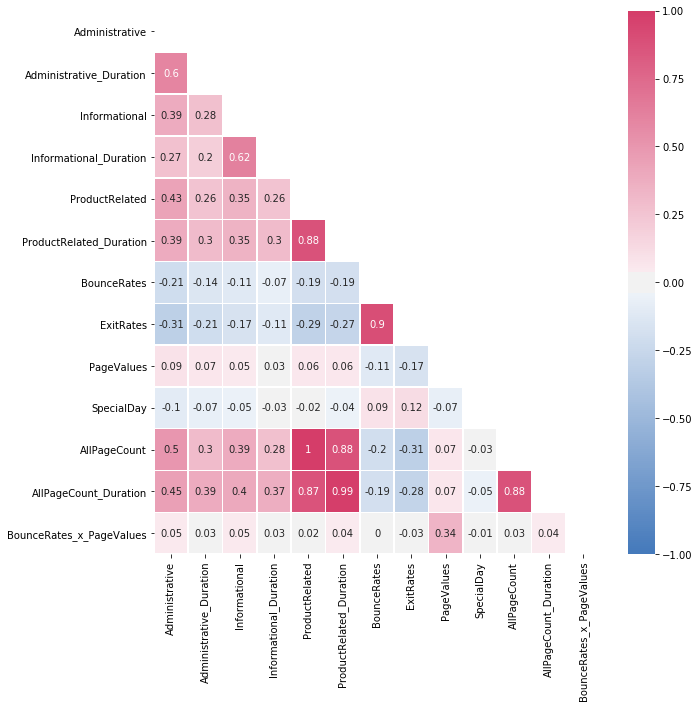

In [32]:
f, ax = plt.subplots(1,1,figsize=(10,10))
plot_corr_heatmap(np.round(train_data[numerical_cols].corr(), 2), ax=ax, annotate=True, annot_size=10)

Drop the columns that have a high correlation with other features

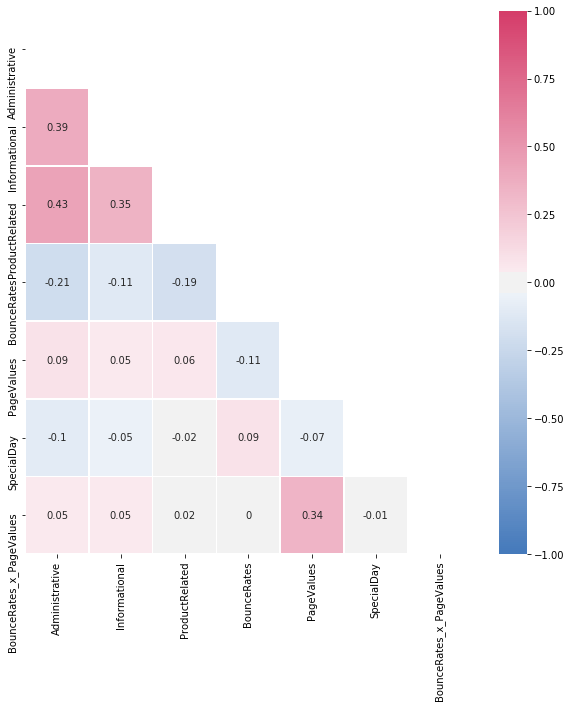

In [33]:
drop_cols = ["Administrative_Duration","Informational_Duration","ProductRelated_Duration", 
             "AllPageCount", "AllPageCount_Duration", "ExitRates"]
numerical_cols = ["Administrative", 
#                   "Administrative_Duration", 
                  "Informational", 
#                   "Informational_Duration",
                  "ProductRelated",
#                   "ProductRelated_Duration", 
#                   "AllPageCount", 
#                   "AllPageCount_Duration",
                  "BounceRates", 
#                   "ExitRates", 
                  "PageValues", 
                  "SpecialDay",
                  "BounceRates_x_PageValues"]
f, ax = plt.subplots(1,1,figsize=(10,10))
plot_corr_heatmap(np.round(train_data[numerical_cols].corr(), 2), ax=ax, annotate=True, annot_size=10)

In [34]:
for c in drop_cols:
    if c in train_data.columns:
        train_data.drop(c, axis=1, inplace=True)

-----------

### Scaling numerical columns

In [35]:
from Utils.PipelineUtils import *

In [36]:
numerical_cols = [ c for c in numerical_cols if c not in drop_cols]
train_data_scaled, scaler_list = scale_collist(train_data, numerical_cols)
display(
    train_data_scaled.shape,
    train_data_scaled.head())

(8543, 19)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,quarter,OperatingSystems_agg,Browser_agg,TrafficType_agg,BounceRates_x_PageValues
0,-0.700298,-0.405807,-0.228228,-0.447944,-0.315005,-0.312378,Nov,2,2,1,8,New_Visitor,False,False,4,2,2,8,-0.168900
1,1.995396,-0.405807,-0.342283,0.093365,-0.315005,-0.312378,May,3,2,4,4,Returning_Visitor,False,False,2,3,2,4,-0.168900
2,5.290134,2.018536,11.063226,-0.350027,0.130124,-0.312378,Nov,1,1,1,2,Returning_Visitor,False,True,4,1,1,2,0.100857
3,-0.700298,-0.405807,-0.616015,2.678117,-0.315005,-0.312378,Nov,3,3,1,3,Returning_Visitor,False,False,4,3,other,3,-0.168900
4,-0.400776,-0.405807,-0.410716,-0.447944,5.847602,-0.312378,Dec,8,13,9,20,Other,False,True,4,other,other,other,-0.168900


-----------

# Categorical columns<a id='catcol'></a>

We need to remove the redundant categorical variables and encode the remaining

In [37]:
train_data_scaled[cat_cols].head()

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,quarter,OperatingSystems_agg,Browser_agg,TrafficType_agg
0,Nov,2,2,1,8,New_Visitor,False,4,2,2,8
1,May,3,2,4,4,Returning_Visitor,False,2,3,2,4
2,Nov,1,1,1,2,Returning_Visitor,False,4,1,1,2
3,Nov,3,3,1,3,Returning_Visitor,False,4,3,other,3
4,Dec,8,13,9,20,Other,False,4,other,other,other


We also established that Browser, Browser_agg and Region have no effect on the Revenue variable (based on ChiSq. tests)

In [38]:
drop_cols = ["OperatingSystems", "Browser", "Browser_agg", "Region", "TrafficType"]
for c in drop_cols:
    if c in train_data_scaled.columns:
        train_data_scaled.drop(c, inplace=True, axis=1)

In [39]:
cat_cols = [c for c in cat_cols if c not in drop_cols]
train_data_scaled[cat_cols].head()

,Month,VisitorType,Weekend,quarter,OperatingSystems_agg,TrafficType_agg
0,Nov,New_Visitor,False,4,2,8
1,May,Returning_Visitor,False,2,3,4
2,Nov,Returning_Visitor,False,4,1,2
3,Nov,Returning_Visitor,False,4,3,3
4,Dec,Other,False,4,other,other


### Encoding Categorical variables

Categorical variables can be One-Hot Encoded after LabelEncoding them.

Columns that are not numerical in nature need to be label_encoded, and then one hot encoded.

In [40]:
for c in cat_cols:
    train_data_scaled[c] = train_data_scaled[c].astype(str)

Note: For months, it may be prudent to encode it manually, as we do not have data for all the months, and they may lose context with the APIs provided.

In [41]:
if "Month" in train_data_scaled.columns:
    for month in months:
        train_data_scaled["Month_"+month] = train_data_scaled["Month"].apply(lambda x: 1 if x==month else 0)
    # Also remove the Month variable from the dataframe
    train_data_scaled.drop("Month", inplace=True, axis=1)
# Update the change in the cat_cols variable
if "Month" in cat_cols:
    cat_cols.remove("Month")

In [42]:
train_data_scaled_encoded, le_list = labelencode_collist(train_data_scaled, cat_cols, inplace=True)
display(train_data_scaled_encoded.shape,
       train_data_scaled_encoded.head())

(8543, 25)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,VisitorType,Weekend,Revenue,quarter,OperatingSystems_agg,TrafficType_agg,BounceRates_x_PageValues,Month_Jan,Month_Feb,Month_Mar,Month_Apr,Month_May,Month_June,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec
0,-0.700298,-0.405807,-0.228228,-0.447944,-0.315005,-0.312378,0,0,False,3,1,8,-0.168900,0,0,0,0,0,0,0,0,0,0,1,0
1,1.995396,-0.405807,-0.342283,0.093365,-0.315005,-0.312378,2,0,False,1,2,5,-0.168900,0,0,0,0,1,0,0,0,0,0,0,0
2,5.290134,2.018536,11.063226,-0.350027,0.130124,-0.312378,2,0,True,3,0,3,0.100857,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.700298,-0.405807,-0.616015,2.678117,-0.315005,-0.312378,2,0,False,3,2,4,-0.168900,0,0,0,0,0,0,0,0,0,0,1,0
4,-0.400776,-0.405807,-0.410716,-0.447944,5.847602,-0.312378,1,0,True,3,3,9,-0.168900,0,0,0,0,0,0,0,0,0,0,0,1


Now we can Label + One hot encode the categorical variables.

In [43]:
train_data_scaled_encoded, ohe_list = onehotencode_collist(train_data_scaled_encoded, cat_cols)
display(train_data_scaled_encoded.shape,
       train_data_scaled_encoded.head())

d:\softwares\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'cate

(8543, 38)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue,BounceRates_x_PageValues,Month_Jan,Month_Feb,Month_Mar,Month_Apr,Month_May,Month_June,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec,VisitorType_0,VisitorType_1,Weekend_0,quarter_0,quarter_1,quarter_2,OperatingSystems_agg_0,OperatingSystems_agg_1,OperatingSystems_agg_2,TrafficType_agg_0,TrafficType_agg_1,TrafficType_agg_2,TrafficType_agg_3,TrafficType_agg_4,TrafficType_agg_5,TrafficType_agg_6,TrafficType_agg_7,TrafficType_agg_8
0,-0.700298,-0.405807,-0.228228,-0.447944,-0.315005,-0.312378,False,-0.168900,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.995396,-0.405807,-0.342283,0.093365,-0.315005,-0.312378,False,-0.168900,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5.290134,2.018536,11.063226,-0.350027,0.130124,-0.312378,True,0.100857,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.700298,-0.405807,-0.616015,2.678117,-0.315005,-0.312378,False,-0.168900,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.400776,-0.405807,-0.410716,-0.447944,5.847602,-0.312378,True,-0.168900,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Save all the components to disk

In [44]:
train_data_scaled_encoded.to_csv("./train_data_scaled_encoded.csv", index=False)
save_to_disk(le_list, "./label_encoders.pkl")
save_to_disk(ohe_list, "./onehot_encoders.pkl")
save_to_disk(traffic_idx_list, "./traffic_idx_list.pkl")
save_to_disk(scaler_list, "./scaler_list.pkl")

------------------